In [115]:
import xml.etree.cElementTree as etree
import string
import subprocess 
import urllib2
import json
import re
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import operator
import community
from random import random


In [116]:
#Fandom wiki: Get links from character pages and put them to 

fandomDump = 'gameofthrones_pages_current.xml'

blacklist = [
    'User',
    'File:',
    'Board',
    'Image',
    'Template',
    'Talk',
    'Battle',
    'Temple',
    'Wall',
    'castle',
    'Sept',
    'category'
    ]

namespacestr = '{http://www.mediawiki.org/xml/export-0.6/}'
namespace = {'mw': 'http://www.mediawiki.org/xml/export-0.6/'}

def nonRestricted(string ):
    for word in blacklist:
        if word.lower() in string:
            return False
    return True

def cleanLink(link):
    split = re.split(r'[|]+', link)
    return split[0].replace(" ", "_")

def findChartersLinks(in_file):
    actorsLinkDic = {}

    for i , (event, elem) in enumerate(etree.iterparse(in_file, events=('start', 'end', 'start-ns', 'end-ns'))):
        if event == 'end' and elem.tag == namespacestr + 'page':
            title = elem.find('.//mw:title', namespace)
            if title is not None: 
                title = title.text.encode('utf-8')
                
                textelem = elem.find('.//mw:text', namespace)
                if textelem is not None and textelem.text is not None and nonRestricted(title.lower()):
                    wiki_text=textelem.text.encode('utf-8')
                    lower_wiki_text = wiki_text.lower()
                    if string.find(lower_wiki_text, "redirect") == -1 and string.find(lower_wiki_text, r'{{character') != -1:
                        link_list = []
                        for link in re.findall(r'\[\[(.*?)\]\]',wiki_text):
                            clink = cleanLink(link)
                            link_list.append(clink)
                        pattern = re.compile(r'{{Character[\s\S]+?}}', re.IGNORECASE)
                        metadata = re.findall(pattern,wiki_text.decode('utf-8'))                    
                        actorsLinkDic[title]={'links': link_list, 'metadata': metadata}                     
                        #print link_list
    return actorsLinkDic

with open('characterLinksDic.json', 'w+') as outfile:
    ActorLinkDic = findChartersLinks(fandomDump)
    json.dump(ActorLinkDic, outfile)

In [117]:
# Create graph from dictionary
with open('characterLinksDic.json', 'r') as outfile:
    characterLinksDic = json.load(outfile)


DG = nx.DiGraph()
G = nx.Graph()

key_links = set()
for key in characterLinksDic:
    key_to_link = key.replace(" ", "_")
    key_links.add(key_to_link)
    DG.add_node(key_to_link)
    G.add_node(key_to_link)
    

for key, value in characterLinksDic.iteritems():
    for link in value['links']:
        if link in key_links:
            key_to_link = key.replace(" ", "_")
            DG.add_edge(key_to_link,link)
            G.add_edge(key_to_link,link)



DGold = DG

### Graph of Raw network

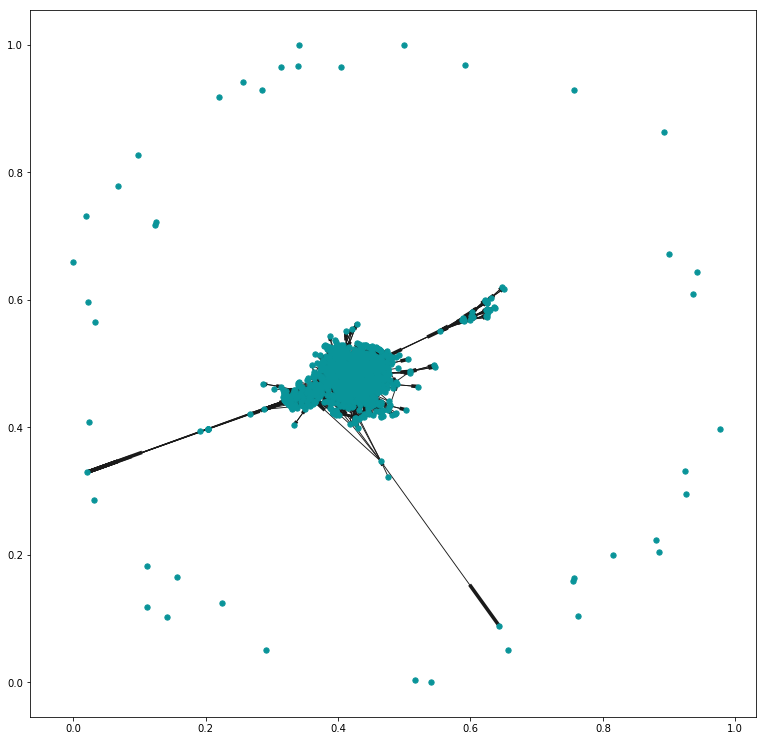

In [118]:
plt.figure(1, figsize=(13, 13))
nx.draw_networkx(DGold, node_size=28, node_color ="#099499", edge_color='.1', with_labels=False, width=0.9, font_color ='#ff0000')
plt.show()

In [119]:


# Delete not important outliers
todelete=['Sandbox/Jon_Snow_(Updated)', 'Whore_(The_Stranger)', 'Great_Master_1_(Kill_the_Boy)','Great_Master_2_(Kill_the_Boy)','Great_Master_3_(Kill_the_Boy)']
DG.remove_nodes_from(todelete)
G.remove_nodes_from(todelete)

# Remove nodes which are not part of main cluster
sub_graphs = nx.connected_component_subgraphs(G)

maximum = 0
for graph in sub_graphs:
    size = graph.number_of_nodes() 
    if size > maximum:
        cluster = graph
        maximum = size

todelete = [x for x in G.nodes() if x not in cluster.nodes()]

DG.remove_nodes_from(todelete)
G.remove_nodes_from(todelete)




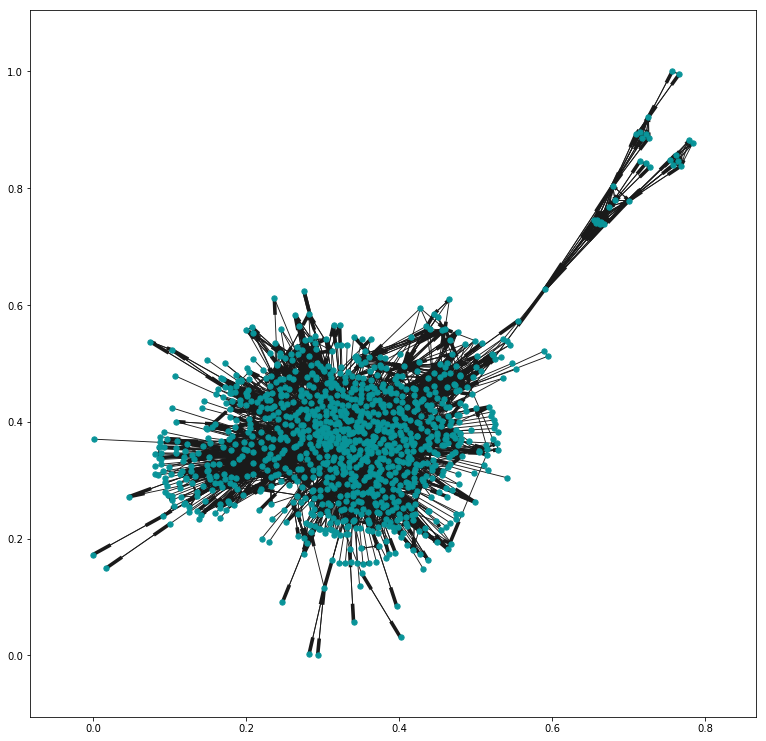

In [120]:
plt.figure(1, figsize=(13, 13))
nx.draw_networkx(DG, node_size=28, node_color ="#099499", edge_color='.1', with_labels=False, width=0.9, font_color ='#ff0000')
plt.show()

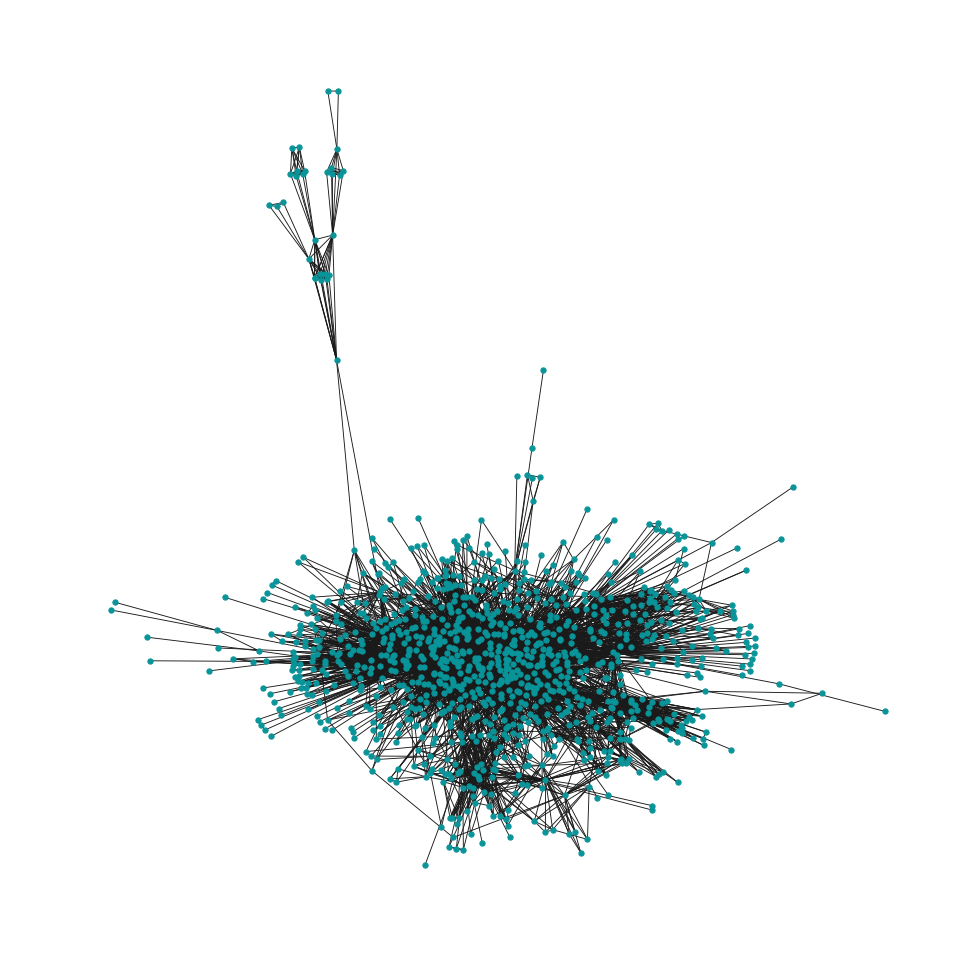

In [121]:
plt.figure(1, figsize=(13, 13))
nx.draw(G, node_size=28, node_color ="#099499", edge_color='.1', with_labels=False, width=0.9, font_color ='#ff0000')
plt.show()

In [122]:
print nx.info(DG)
degrees = [DG.degree(nodes) for nodes in DG.nodes()]
print 'Median degree: %s' %np.median(degrees)




Name: 
Type: DiGraph
Number of nodes: 1064
Number of edges: 9249
Average in degree:   8.6927
Average out degree:   8.6927
Median degree: 8.0


In [123]:
inDegree = DG.in_degree()
outDegree = DG.out_degree()

sorted_inDegree = sorted(inDegree.items(), key=operator.itemgetter(1), reverse = True)
sorted_outDegree = sorted(outDegree.items(), key=operator.itemgetter(1), reverse = True)

print 'Top 10 in-degree \n [%s] \n' % '\n '.join(map(str, sorted_inDegree[:10]))
print 'Top 10 out-degree \n [%s] \n' % '\n '.join(map(str, sorted_outDegree[:10]))



Top 10 in-degree 
 [(u'Tyrion_Lannister', 197)
 (u'Jon_Snow', 174)
 (u'Daenerys_Targaryen', 160)
 (u'Jaime_Lannister', 149)
 (u'Robb_Stark', 148)
 (u'Eddard_Stark', 138)
 (u'Sansa_Stark', 134)
 (u'Stannis_Baratheon', 129)
 (u'Joffrey_Baratheon', 127)
 (u'Cersei_Lannister', 126)] 

Top 10 out-degree 
 [(u'Jon_Snow', 83)
 (u'Tyrion_Lannister', 81)
 (u'Arya_Stark', 68)
 (u'Jaime_Lannister', 67)
 (u'Sansa_Stark', 66)
 (u'Daenerys_Targaryen', 65)
 (u'Robb_Stark', 63)
 (u'Cersei_Lannister', 60)
 (u'Eddard_Stark', 59)
 (u'Ramsay_Bolton', 58)] 



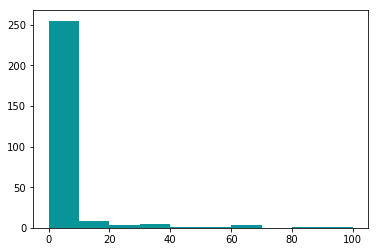

In [124]:
histogram_list = nx.degree_histogram(DG)

plt.hist(histogram_list, color="#099499")
plt.show()

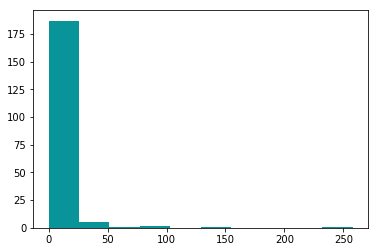

In [125]:
svIn = [val for key, val in inDegree.iteritems()]

bins = range(min(svIn), max(svIn) + 1)
inDegree_hist, inDegree_bin = np.histogram(svIn, bins=bins)

plt.hist(inDegree_hist, color="#099499")
plt.show()

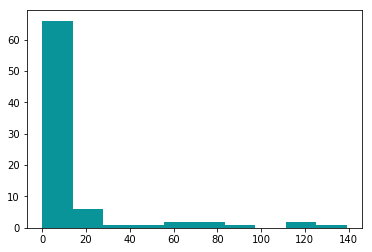

In [126]:
svOut = [val for key, val in outDegree.iteritems()]

bins = range(min(svOut), max(svOut) + 1)
outDegree_hist, inDegree_bin = np.histogram(svOut, bins=bins)

plt.hist(outDegree_hist, color="#099499")
plt.show()

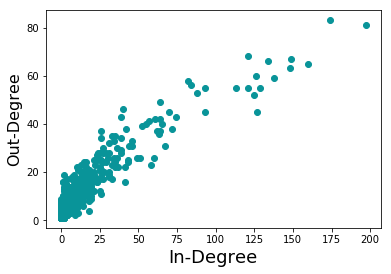

In [127]:
plt.scatter(svIn, svOut, color="#099499")
plt.xlabel('In-Degree', fontsize=18)
plt.ylabel('Out-Degree', fontsize=16)
plt.show()

In [128]:
for node in outDegree:
    if (outDegree[node] == 0 or inDegree[node] ==0) and outDegree[node] > 10:
        print node, outDegree[node], inDegree[node]
     

In [129]:
#first compute the best partition
import community
GCC = max(nx.connected_component_subgraphs(G), key=len)
partition = community.best_partition(G)

communityList = []

for x in range (0,max(partition.values())):
    tempList = []
    for char, val in partition.items():
        if x == val:
            tempList.append(char)
    if len(tempList) > 4:
        communityList.append(tempList)

In [134]:
#drawing
from random import random
plt.rcParams['image.cmap'] = 'tab20c'
plt.figure(figsize=(16,12))

size = float(len(set(partition.values())))
pos = nx.spring_layout(GCC)
count = 0

colors = [(random(), random(), random()) for _i in range(len(set(partition.values())))]



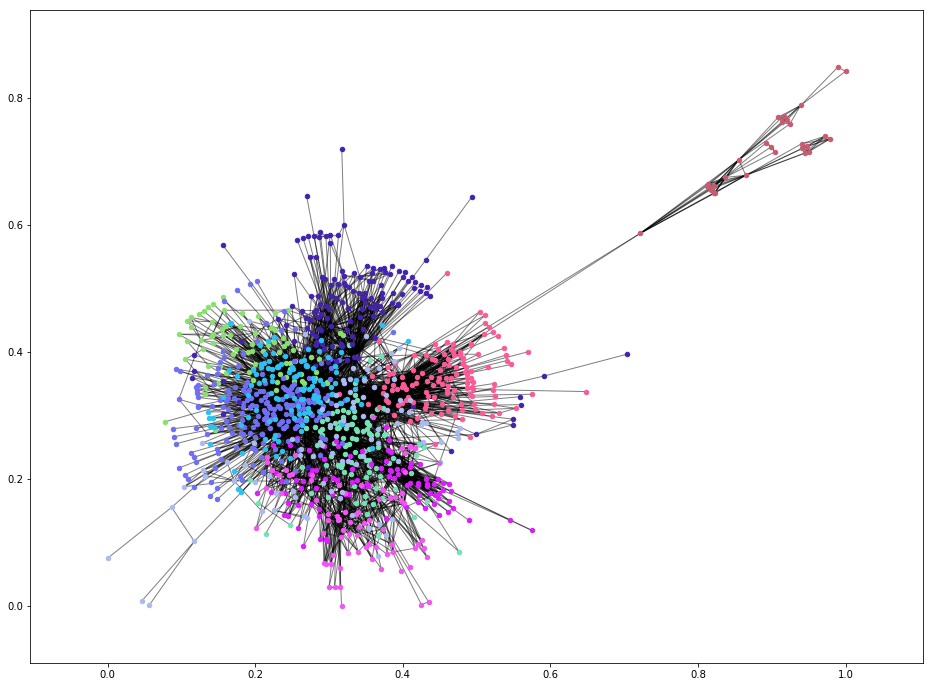

In [135]:
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(GCC, pos, list_nodes, node_size = 20,
                                node_color = colors[count])
    count +=1

nx.draw_networkx_edges(GCC,pos, alpha=0.5)

plt.show()

In [132]:
modularityAlgorithm = 0.0
modularityAlgorithm = community.modularity(partition, GCC)
print 'The modularity of the communities is: M = ', modularityAlgorithm

The modularity of the communities is: M =  0.518019753309


In [133]:
BC = nx.betweenness_centrality(G)

sorted_BC = sorted(BC.items(), key=operator.itemgetter(1))
print 'The 10 most central ch using betweennes centrality: \n [%s] \n' % '\n '.join(map(str, reversed(sorted_BC[-10:])))

The 10 most central ch using betweennes centrality: 
 [(u'Daenerys_Targaryen', 0.14802805267106176)
 (u'Jon_Snow', 0.1392122262672052)
 (u'Tyrion_Lannister', 0.09574072590925017)
 (u'Arya_Stark', 0.06078838865358915)
 (u'Robb_Stark', 0.05987853353896647)
 (u'Jaime_Lannister', 0.05884258561242504)
 (u'Stannis_Baratheon', 0.054318425285888254)
 (u'Morag_Umber', 0.051341741473603646)
 (u'Joffrey_Baratheon', 0.04543818885563213)
 (u'Craster', 0.04484105949844914)] 

